# Проект 'Выбор локации для скважины'

## Загрузка и подготовка данных

### Импортируем библиотеки.

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Константы

Некоторые константы, которые понадобятся нам далее при расчёте прибыли.

In [6]:
BUDGET = 1e10
INCOME_PER_1000_BBL = 450 * 10**3
BOREHOLS = 200

### Считываем данные и выводим общую информацию.

In [7]:
try:
    data_0 = pd.read_csv('datasets/geo_data_0.csv')
    data_1 = pd.read_csv('datasets/geo_data_1.csv')
    data_2 = pd.read_csv('datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('geo_data_0.csv')
    data_1 = pd.read_csv('geo_data_1.csv')
    data_2 = pd.read_csv('geo_data_2.csv')

In [8]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Далее будем рассматривать только **data_0**, т.к. у датафреймов отличаются лишь конкретные характеристики объектов.

In [9]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Первые 5 строчек датасета.

In [10]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Теперь придётся рассмотреть каждый датасет. \
Гистограммы всех числовых столбцов.

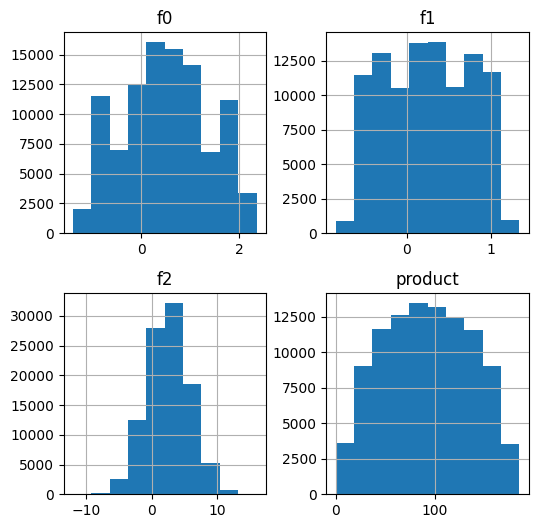

In [11]:
data_0.hist(figsize=(6,6));

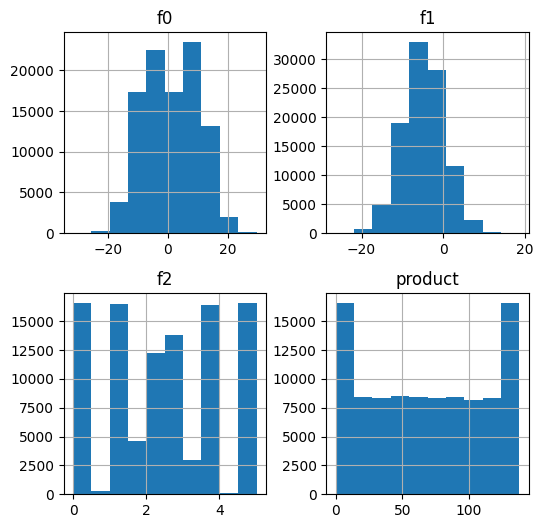

In [12]:
data_1.hist(figsize=(6,6));

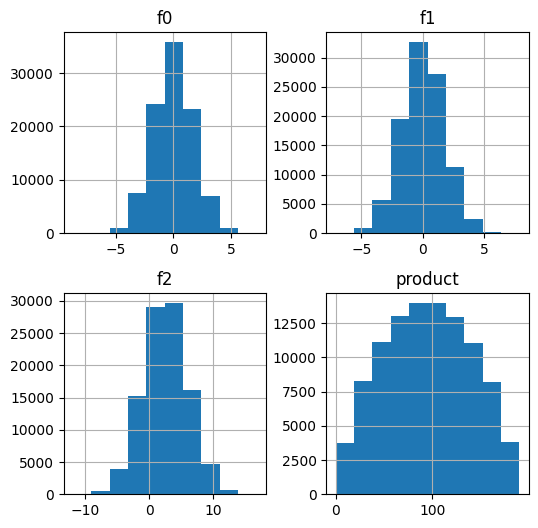

In [13]:
data_2.hist(figsize=(6,6));

###  Изучим особенности данных.

Сначала проверим даннные на наличие дубликатов.

In [14]:
display(data_0.duplicated().sum())
display(data_1.duplicated().sum())
display(data_2.duplicated().sum())

0

0

0

Их нет - можем двигаться дальше.

In [15]:
display(data_0.isna().sum())
display(data_1.isna().sum())
display(data_2.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропусков тоже не наблюдается!

### Проверим зависимости

In [23]:
print('Корреляционная матрица для региона №0:')
data_0.loc[:, 'f0':].corr().style.background_gradient(cmap='bwr')

Корреляционная матрица для региона №0:


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [24]:
print('Корреляционная матрица для региона №1:')
data_1.loc[:, 'f0':].corr().style.background_gradient(cmap='bwr')

Корреляционная матрица для региона №1:


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [25]:
print('Корреляционная матрица для региона №2:')
data_2.loc[:, 'f0':].corr().style.background_gradient(cmap='bwr')

Корреляционная матрица для региона №2:


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Судя по таблицам, самым значимым признаком является **f2**. Объёмы запасов нефти зависят от него на **0.48**, **0.99** и **0.45** в каждом из 3-х регионов соответственно. Также в нулевом регионе присутствует отрицательная корреляция (**-0.44**) между **f0** и **f1**. 

### Подготовим данные

Столбец `id` мы использовать не будем (т.к. это просто кодовый номер месторождения), а все остальные признаки численные. Следовательно, преобразовывать никакие категориальные переменные нет необходимости.

Теперь выясним придётся ли нам прибегнуть к масштабированию. Для этого проверим границы значений каждого.

In [26]:
def borders(n, data):
    table = data.agg(['min', 'max'])
    print(f"Границы признаков региона №{n}:\n{table}\n")

In [27]:
borders(0, data_0.loc[:, 'f0':'f2'])
borders(1, data_1.loc[:, 'f0':'f2'])
borders(2, data_2.loc[:, 'f0':'f2'])

Границы признаков региона №0:
           f0        f1         f2
min -1.408605 -0.848218 -12.088328
max  2.362331  1.343769  16.003790

Границы признаков региона №1:
            f0         f1        f2
min -31.609576 -26.358598 -0.018144
max  29.421755  18.734063  5.019721

Границы признаков региона №2:
           f0        f1         f2
min -8.760004 -7.084020 -11.970335
max  7.238262  7.844801  16.739402



Мы видим, что разброс у них не очень большой. Однако этого может хватить, чтобы какой-либо из признаков случайно стал более значимым. Так что после разбиения данных на выборки выполним масштабирование.

### Вывод

В нашем распоряжении 3 датасета с информацией о нефтяных скважинах в регионах. В данных нет пропусков и дубликатов, а между некоторыми признаками присутствуют зависимости. Подготовка данных не потребовалась, так как все необходимые столбцы числовые. \
Приступим к построению моделей.

## Обучение и проверка моделей

### Средний запас и RMSE

Для каждого региона придётся создавать свою модель, поэтому напишем специальную функцию. 

In [28]:
def region_model(data, show):
    # выделим признаки и ответы
    features = data.drop(['product','id'], axis=1)
    target = data['product']
    
    # разобьём данные на обучающую и валидационную выборки
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345)
    # масштабируем признаки
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    # обучим модель и сохраним предсказания на валидационной выборке
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = pd.Series(model.predict(features_valid))
    
    # считаем средний запас предсказанного сырья и RMSE модели
    average_product = predictions_valid.mean()        
    rmse = (mean_squared_error(predictions_valid, target_valid))**0.5
    if show:
        # напечатаем на экране 
        print('Средний запас предсказанного сырья: {0:.2f}'.format(average_product))
        print('RMSE модели: {0:.2f}'.format(rmse))
    else:
        # возвращаем предсказания и правильные валидационные ответы, RMSE
        return (predictions_valid, target_valid.reset_index(drop=True), rmse)    

In [29]:
i = 0
for region in [data_0, data_1, data_2]:
    print(f'Регион №{i}:')
    region_model(region, 1)
    print()
    i += 1

Регион №0:
Средний запас предсказанного сырья: 92.59
RMSE модели: 37.58

Регион №1:
Средний запас предсказанного сырья: 68.73
RMSE модели: 0.89

Регион №2:
Средний запас предсказанного сырья: 94.97
RMSE модели: 40.03



Судя по полученным числам, в регионе №2 самый большой средний запас сырья, а модель для региона №1 имеет самую низкую среднеквадратичную ошибку.

Сохраним эти результаты.

In [30]:
predictions_0, true_0, rmse_0 = region_model(data_0, 0)
predictions_1, true_1, rmse_1 = region_model(data_1, 0)
predictions_2, true_2, rmse_2 = region_model(data_2, 0)

###  Вывод
Мы разбили данные на выборки, масштабировали признаки, обучили модели, посчитали средний запас предсказанного сырья и RMSE моделей. Результаты проанализировали и сохранили в отдельные переменные.

## Подготовка к расчёту прибыли

###  Ключевые значения для расчётов

Нам необходимо знать:
- бюджет на разработку скважин в регионе (`10 млрд руб.`)
- доход с каждой единицы продукта (`450 руб. за баррель`)
- итогое количество скважин, которые будут разработаны (`200`)

Данные константы мы объявили заранее в самом начале проекта. Теперь используем их. 

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

Согласно определению, `точка безубыточности - это объём производства и реализации продукции, при котором расходы будут компенсированы доходами`. Поэтому формула для её нахождения выглядит так: 

In [31]:
breakeven = BUDGET / INCOME_PER_1000_BBL
print('Точка безубыточности: {0:.0f} тыс. баррелей'.format(breakeven))

Точка безубыточности: 22222 тыс. баррелей


Следовательно, при таком объёме нефти в регионе мы не будем иметь убытков. Но в конечном итоге нужно выбрать всего 200 лучших месторождений. Найдём средний объём запасов, который должна иметь каждая из этих точек: 

In [32]:
print('Средний объем нефти в скважине для безубыточного функционирования:', np.ceil(breakeven / 200))

Средний объем нефти в скважине для безубыточного функционирования: 112.0


А теперь сравним полученный объём сырья со средним запасом в каждом регионе.

In [33]:
print('Регион №0: {0:.0f}'.format(data_0['product'].mean()))
print('Регион №1: {0:.0f}'.format(data_1['product'].mean()))
print('Регион №2: {0:.0f}'.format(data_2['product'].mean()))

Регион №0: 93
Регион №1: 69
Регион №2: 95


Выбрав случайные скважины мы денег точно не заработаем. Все средние ниже точки безубыточности.

### Напишем функцию для расчёта прибыли

In [34]:
def revenue(predictions, target):
    # скважины с максимальными значениями предсказаний
    top_preds = predictions.sort_values(ascending=False)
    # просуммируем целевое значение объёма сырья, соответствующее  
    # этим предсказаниям и найдём прибыль
    top_target = target[top_preds.index][:BOREHOLS]
    total_income = top_target.sum() * INCOME_PER_1000_BBL
    return total_income - BUDGET

### Вывод
Мы сохранили ключевые значения (бюджет и цена на 1 баррель нефти), нашли точку безубыточности, а также создали функцию расчёта прибыли.

## Расчёт прибыли и рисков 

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [35]:
state = np.random.RandomState(12345)

In [36]:
def risks_and_toffees(predictions, target):
    values = []
    
    # процедура Bootstrap
    for i in range(1000):
        target_subsample = target.sample(500, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        values.append(revenue(predictions_subsample, target_subsample))
    values = pd.Series(values)
    
    # средняя прибыль, 95%-й доверительный интервал и риск убытков
    mean_revenue = int(values.mean())
    lower = int(np.percentile(values, 2.5)); higher = int(np.percentile(values, 97.5))
    interval = (lower, higher)
    risk = st.percentileofscore(values, 0)
    
    # вывод на экран
    print(f'Средняя прибыль: {mean_revenue}')
    print(f'95%-й доверительный интервал: {interval}')
    print(f'Риск убытков: {risk}')

In [ ]:
i = 0
zipped = zip([predictions_0, predictions_1, predictions_2], 
             [true_0, true_1, true_2]) 
for predictions, target in zipped:
    print(f'Регион №{i}:')
    risks_and_toffees(predictions, target)
    print()
    i += 1

### Вывод
Мы успешно применили Bootstrap и нашли среднюю прибыль, риск убытков и 95%-й доверительный интервал для каждого региона. Также, полученная информация позволяет выбрать самый перспективный регион для разработки скважин. \
И это **регион №1**, т.к. у него: 
- минимальный риск убытков (`0.3`)
- максимальная средняя прибыль (`~518 млн руб.`)

## Общий вывод
Мы использовали данные о нефтяных месторождениях в 3-х регионах, чтобы оценить прибыльность вложений.
1) Данные были изучены и подготовлены к обучению моделей (проверены зависимости; отброшены лишние данные; признаки масштабированы и разделены на 2 выборки). \
2) Для каждого региона мы создали и обучили модель линейной регрессии. Посчитали среднеквадратичную ошибку и средний запас предсказанного сырья. \
3) Выделили ключевые константы для расчётов и сравнили точку безубыточности с реальной ситуацией по всем скважинам регионов. \
4) Применили технику Bootstrap и нашли 95% доверительный интервал для среднего объема нефти в скважинах. Проанализировали риски, среднюю прибыль и выбрали **регион №1**.